In [12]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: C:\Users\LAB1\Desktop\dev\personal_project\systematic-trading-framework


In [13]:
import matplotlib.pyplot as plt

from src.data.loaders import load_ohlcv
from src.data.validation import validate_ohlcv

from src.features import (
    add_close_returns,
    add_volatility_features,
)

from src.features.technical.trend import (
    add_trend_features,
    add_trend_regime_features,
)

from src.features.technical.momentum import (
    add_momentum_features,
)


In [14]:
df = load_ohlcv("SPY", start="2020-01-01", interval="1d")
validate_ohlcv(df)

df.head()


Price,open,high,low,close,volume
Date,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000


In [15]:
df = add_close_returns(df, log=True)

df = add_volatility_features(
    df,
    returns_col="close_logret",
    rolling_windows=(20,),
    ewma_spans=(20,),
)

df[
    ["close", "close_logret", "vol_rolling_20", "vol_ewma_20"]
].tail()


Price,close,close_logret,vol_rolling_20,vol_ewma_20
Date,,,,
2026-01-23,689.229980,0.000363,0.105486,0.122262
2026-01-26,692.729980,0.005065,0.106295,0.118555
2026-01-27,695.489990,0.003976,0.107139,0.113849
2026-01-28,695.419983,-0.000101,0.106148,0.108423
2026-01-29,694.039978,-0.001986,0.106352,0.104056


In [16]:
df = add_trend_features(
    df,
    price_col="close",
    sma_windows=(20, 50),
    ema_spans=(20,),
)

df = add_trend_regime_features(
    df,
    price_col="close",
    base_sma_for_sign=50,
    short_sma=20,
    long_sma=50,
)

df[
    [
        "close",
        "close_sma_20",
        "close_sma_50",
        "close_trend_regime_sma_50",
        "close_trend_state_sma_20_50",
    ]
].tail()


Price,close,close_sma_20,close_sma_50,close_trend_regime_sma_50,close_trend_state_sma_20_50
Date,,,,,
2026-01-23,689.229980,688.885495,681.932201,1.0,1.0
2026-01-26,692.729980,689.002994,682.126801,1.0,1.0
2026-01-27,695.489990,689.261993,682.369000,1.0,1.0
2026-01-28,695.419983,689.640494,682.836600,1.0,1.0
2026-01-29,694.039978,689.991992,683.278800,1.0,1.0


In [17]:
df = add_momentum_features(
    df,
    price_col="close",
    returns_col="close_logret",
    vol_col="vol_rolling_20",
    windows=(5, 20, 60),
)

df[
    [
        "close",
        "close_logret_mom_20",
        "close_logret_norm_mom_20",
        "close_trend_state_sma_20_50",
    ]
].tail()


Price,close,close_logret_mom_20,close_logret_norm_mom_20,close_trend_state_sma_20_50
Date,,,,
2026-01-23,689.229980,0.001844,0.017484,1.0
2026-01-26,692.729980,0.003398,0.031969,1.0
2026-01-27,695.489990,0.007476,0.069777,1.0
2026-01-28,695.419983,0.010945,0.103112,1.0
2026-01-29,694.039978,0.010181,0.095727,1.0


In [18]:
df[
    [
        "close_logret_mom_20",
        "close_logret_norm_mom_20",
        "close_trend_state_sma_20_50",
    ]
].describe()


Price,close_logret_mom_20,close_logret_norm_mom_20,close_trend_state_sma_20_50
count,1507.000000,1507.000000,1527.000000
mean,0.009901,0.124920,0.421742
std,0.052991,0.271142,0.889136
min,-0.376735,-0.761268,-1.000000
25%,-0.009749,-0.055981,-1.000000
50%,0.018660,0.142706,1.000000
75%,0.038972,0.303815,1.000000
max,0.207604,1.047614,1.000000


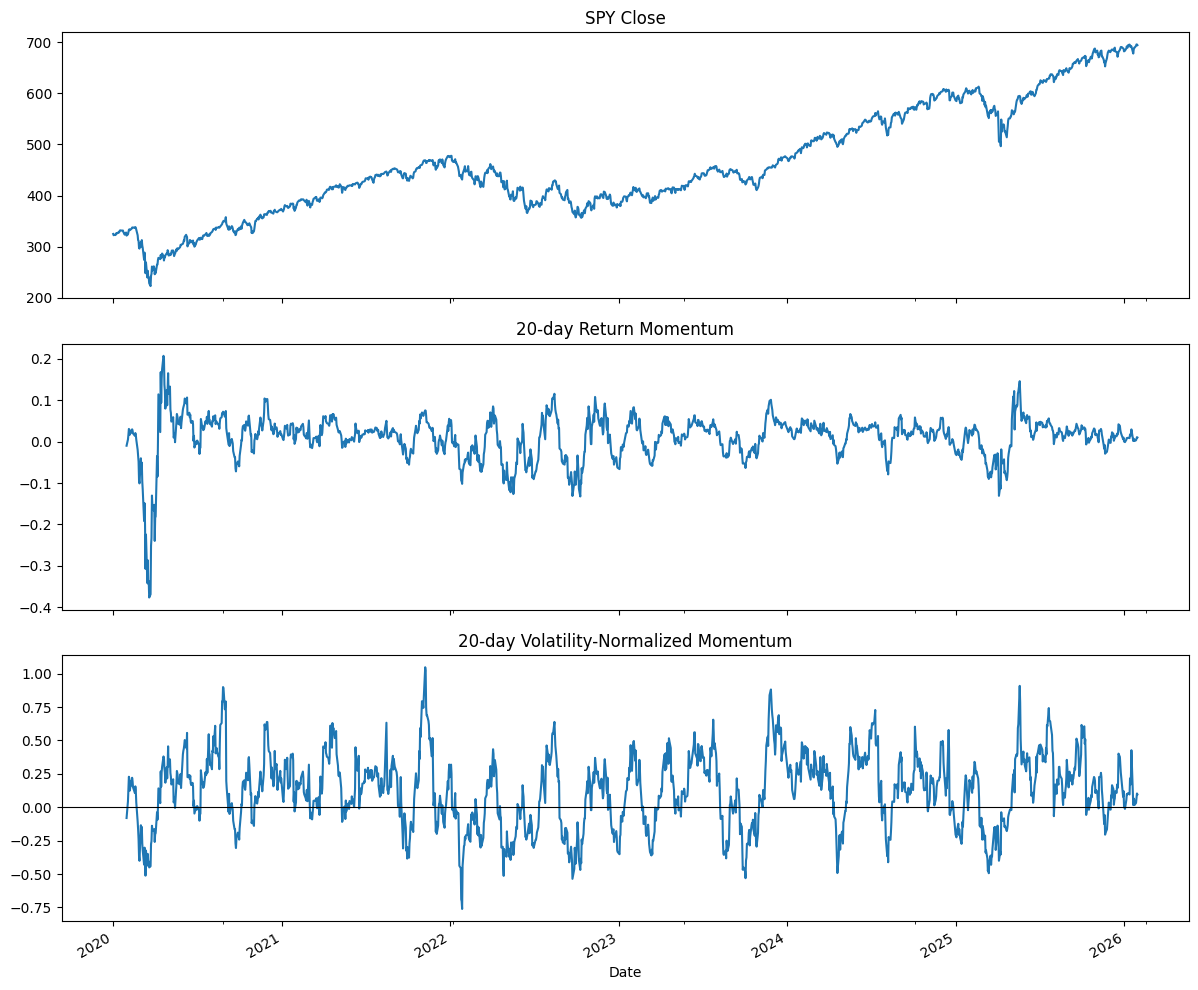

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

df["close"].plot(ax=axes[0])
axes[0].set_title("SPY Close")

df["close_logret_mom_20"].plot(ax=axes[1])
axes[1].set_title("20-day Return Momentum")

df["close_logret_norm_mom_20"].plot(ax=axes[2])
axes[2].set_title("20-day Volatility-Normalized Momentum")
axes[2].axhline(0, color="black", linewidth=0.8)

plt.tight_layout()


In [20]:
bull = df[df["close_trend_state_sma_20_50"] == 1]
bear = df[df["close_trend_state_sma_20_50"] == -1]

bull["close_logret_norm_mom_20"].describe(), bear["close_logret_norm_mom_20"].describe()


(count    1061.000000
 mean        0.203236
 std         0.244664
 min        -0.513634
 25%         0.045744
 50%         0.215903
 75%         0.363653
 max         1.047614
 Name: close_logret_norm_mom_20, dtype: float64,
 count    417.000000
 mean      -0.060786
 std        0.238630
 min       -0.761268
 25%       -0.241501
 50%       -0.085572
 75%        0.131256
 max        0.599886
 Name: close_logret_norm_mom_20, dtype: float64)

### Log-Returns

Για τιμή κλεισίματος \( P_t \), οι λογαριθμικές αποδόσεις ορίζονται ως:

$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$

όπου:
- \( P_t \): τιμή στο χρόνο \( t \)
- \( r_t \): log-return στο χρόνο \( t \).

---

### Rolling Volatility (Realized Vol)

Για παράθυρο \( n \) περιόδων, η rolling volatility ορίζεται ως:

$$
\sigma_t =
\sqrt{
\frac{1}{n - 1}
\sum_{i=0}^{n-1} \left(r_{t-i} - \bar r_t\right)^2
}
$$

όπου:
- \( r_{t-i} \): log-returns των τελευταίων \( n \) περιόδων,
- \( \bar r_t \): ο μέσος όρος των \( r_{t-i} \) στο παράθυρο.

Η annualized volatility (για daily δεδομένα) είναι:

$$
\sigma_t^{(\text{ann})} = \sigma_t \sqrt{252}
$$

---

### EWMA Volatility

Η EWMA volatility ορίζεται ως:

$$
\sigma_t^2 = (1 - \lambda)
\sum_{k=0}^{\infty} \lambda^k r_{t-k}^2
$$

με:

$$
\lambda = \frac{2}{\text{span} + 1}
$$

και πάλι, η annualized μορφή:

$$
\sigma_t^{(\text{ann})} = \sigma_t \sqrt{252}
$$


### Simple Moving Average (SMA)

Για τιμή \( P_t \) και παράθυρο \( n \):

$$
\text{SMA}^{(n)}_t = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}
$$

---

### Exponential Moving Average (EMA)

Η EMA ορίζεται αναδρομικά ως:

$$
\text{EMA}_t = \alpha P_t + (1 - \alpha)\,\text{EMA}_{t-1},
\quad
\alpha = \frac{2}{\text{span} + 1}
$$

---

### Σχετική Τιμή ως προς SMA / EMA

Ορίζουμε το σχετικό επίπεδο τιμής ως:

$$
\text{rel\_SMA}^{(n)}_t =
\frac{P_t}{\text{SMA}^{(n)}_t} - 1
$$

και αντίστοιχα για EMA:

$$
\text{rel\_EMA}^{(\text{span})}_t =
\frac{P_t}{\text{EMA}^{(\text{span})}_t} - 1
$$


### Trend Regime vs Slow SMA

Για μια "αργή" SMA (π.χ. 50 ημερών), ορίζουμε trend regime:

$$
\text{Regime}^{(50)}_t =
\operatorname{sign}\left(
\frac{P_t}{\text{SMA}^{(50)}_t} - 1
\right)
\in \{-1, 0, 1\}
$$

- \( +1 \): τιμή πάνω από SMA ⇒ bull bias  
- \( -1 \): τιμή κάτω από SMA ⇒ bear bias  
- \( 0 \): ουδέτερο / μη διαθέσιμο σήμα.

---

### Double MA State (Short vs Long)

Για δύο SMA, short (π.χ. 20) και long (π.χ. 50):

$$
\text{State}^{(20,50)}_t =
\begin{cases}
1, & \text{αν } \text{SMA}^{(20)}_t > \text{SMA}^{(50)}_t \\
-1, & \text{αν } \text{SMA}^{(20)}_t < \text{SMA}^{(50)}_t \\
0, & \text{αλλιώς (ουδέτερο / NaN)}
\end{cases}
$$

Αυτό είναι ένα **discrete trend regime feature**:
- \( +1 \): uptrend  
- \( -1 \): downtrend  
- \( 0 \): neutral / no-info.


### Price Momentum

Για τιμές \( P_t \) και παράθυρο \( k \):

$$
\text{PriceMomentum}^{(k)}_t =
\frac{P_t}{P_{t-k}} - 1
$$

---

### Return-Based Momentum (Log-Returns)

Για log-returns \( r_t \) και παράθυρο \( k \):

$$
\text{ReturnMomentum}^{(k)}_t =
\sum_{i=1}^{k} r_{t-i}
$$

Για log-returns αυτό ισοδυναμεί με:

$$
\text{ReturnMomentum}^{(k)}_t =
\log\left(\frac{P_{t-1}}{P_{t-k-1}}\right)
$$

δηλαδή ένα cumulative log-return σε rolling παράθυρο.

---

### Volatility-Normalized Momentum

Δεδομένης μιας volatility σειράς \( \sigma_t \) (π.χ. rolling vol):

$$
\text{NormMomentum}^{(k)}_t =
\frac{
\sum_{i=1}^{k} r_{t-i}
}{
\sigma_t + \varepsilon
}
$$

όπου \( \varepsilon \) ένα πολύ μικρό θετικό (π.χ. \( 10^{-8} \)) για αποφυγή διαίρεσης με μηδέν.

Αυτό το μέγεθος είναι ουσιαστικά
**momentum σε "μονάδες" ρίσκου** (Sharpe-like signal).


### Momentum Conditioned on Trend Regime

Αναλύουμε τη συμπεριφορά του volatility-normalized momentum
υπό διαφορετικά καθεστώτα trend:

- Bull regime: \( \text{State}^{(20,50)}_t = 1 \)
- Bear regime: \( \text{State}^{(20,50)}_t = -1 \)

Εμπειρικά παρατηρούμε ότι:

$$
\mathbb{E}\left[
\text{NormMomentum}^{(k)}_t
\mid
\text{State}^{(20,50)}_t = 1
\right] > 0
$$

$$
\mathbb{E}\left[
\text{NormMomentum}^{(k)}_t
\mid
\text{State}^{(20,50)}_t = -1
\right] < 0
$$

δηλαδή το momentum λειτουργεί πολύ διαφορετικά
σε bull vs bear καθεστώτα,
κάτι που δικαιολογεί τη χρήση
**regime filters** σε momentum-based στρατηγικές.


In [21]:
df.tail(100)

Price,open,high,low,close,volume,close_logret,vol_rolling_20,vol_ewma_20,close_sma_20,close_over_sma_20,...,close_trend_state_sma_20_50,close_mom_5,close_logret_mom_5,close_logret_norm_mom_5,close_mom_20,close_logret_mom_20,close_logret_norm_mom_20,close_mom_60,close_logret_mom_60,close_logret_norm_mom_60
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-08,648.619995,649.840027,647.229980,648.830017,63133100,0.002454,0.093601,0.095878,643.569995,0.008173,...,1.0,0.005860,0.005843,0.062424,0.018284,0.018119,0.193572,0.078938,0.075977,0.811708
2025-09-09,648.969971,650.859985,647.219971,650.330017,66133900,0.002309,0.093085,0.091410,644.290497,0.009374,...,1.0,0.015712,0.015590,0.167482,0.022660,0.022407,0.240719,0.077151,0.074320,0.798411
2025-09-10,653.619995,654.549988,650.630005,652.210022,78034500,0.002887,0.086472,0.087351,644.766498,0.011545,...,1.0,0.013158,0.013072,0.151167,0.014813,0.014704,0.170044,0.092479,0.088450,1.022865
2025-09-11,654.179993,658.330017,653.590027,657.630005,69934400,0.008276,0.090114,0.089530,645.403497,0.018944,...,1.0,0.013110,0.013025,0.144538,0.019755,0.019563,0.217088,0.091176,0.087256,0.968284
2025-09-12,657.599976,659.109985,656.900024,657.409973,72780100,-0.000335,0.090183,0.085867,646.026495,0.017621,...,1.0,0.015713,0.015591,0.172879,0.019319,0.019135,0.212181,0.100212,0.095503,1.058999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-23,688.150024,690.960022,687.159973,689.229980,63059600,0.000363,0.105486,0.122262,688.885495,0.000500,...,1.0,-0.004348,-0.004358,-0.041311,0.001846,0.001844,0.017484,0.005823,0.005806,0.055039
2026-01-26,690.489990,694.130005,689.919983,692.729980,60473800,0.005065,0.106295,0.118555,689.002994,0.005409,...,1.0,0.001547,0.001546,0.014543,0.003404,0.003398,0.031969,0.008253,0.008219,0.077320
2026-01-27,694.179993,696.530029,693.570007,695.489990,55506100,0.003976,0.107139,0.113849,689.261993,0.009036,...,1.0,0.026432,0.026089,0.243506,0.007504,0.007476,0.069777,0.011784,0.011715,0.109342


In [22]:
for col in df.columns:
    print(col)
    print(df[col].describe())
    print("=" * 50)

open
count    1527.000000
mean      460.103307
std       105.056441
min       228.190002
25%       390.300003
50%       437.859985
75%       543.000000
max       697.049988
Name: open, dtype: float64
high
count    1527.000000
mean      462.793543
std       104.948854
min       229.679993
25%       393.029999
50%       440.299988
75%       546.059998
max       697.840027
Name: high, dtype: float64
low
count    1527.000000
mean      457.194839
std       104.998981
min       218.259995
25%       387.485001
50%       435.320007
75%       539.515015
max       693.940002
Name: low, dtype: float64
close
count    1527.000000
mean      460.195888
std       105.031380
min       222.949997
25%       390.099991
50%       437.890015
75%       542.595001
max       695.489990
Name: close, dtype: float64
volume
count    1.527000e+03
mean     8.011277e+07
std      3.972272e+07
min      2.604870e+07
25%      5.723235e+07
50%      7.228740e+07
75%      9.149815e+07
max      3.922207e+08
Name: volume, dty